# Differentiable Physics Model: Lorenz System


In [1]:
import autoroot  # noqa: F401, I001
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import diffrax as dfx

# from jaxsw._src.models.lorenz63 import Lorenz63
# from jaxsw._src.models.lorenz96 import Lorenz96
from jaxsw._src.models.lorenz63 import L63State, Lorenz63, rhs_lorenz_63

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Lorenz 63

* Equation of Motion
* Observation Operator
* Integrate

### Equation of Motion

$$
\begin{aligned}
\frac{dx}{dt} &= \sigma (y - x) \\
\frac{dy}{dt} &= x (\rho - z) - y \\
\frac{dz}{dt} &= xy - \beta z
\end{aligned}
$$

where $(\sigma,\rho,\beta)$ are hyperparameters.

In [2]:
s, r, b = 10, 28, 2.667

In [3]:
# initialize state
state = L63State.init_state(noise=0.01)

# rhs
x, y, z = state.x, state.y, state.z
state_dot = rhs_lorenz_63(state=(x, y, z), s=s, r=r, b=b)

x_dot, y_dot, z_dot = state_dot

assert x.shape == y.shape == z.shape == x_dot.shape
assert x_dot.shape == y_dot.shape == z_dot.shape == x.shape

### Model

In [5]:
t0 = 0.0
t1 = 30.0

# initialize state
state = L63State.init_state(noise=0.01)

# initialize model
l63_model = Lorenz63(tmin=t0, tmax=t1, s=s, b=b, r=r)

# step through
state_dot = l63_model.equation_of_motion(t=0, state=state, args=None)

state_dot

L63State(x=Array(0.07530808, dtype=float32), y=Array(25.796667, dtype=float32), z=Array(-1.6745309, dtype=float32))

## Time Stepping

In [6]:
dt = 0.01
t0 = 0.0
t1 = 30.0
# observe_every = 10

saveat = dfx.SaveAt(t0=t0, t1=t1, ts=jnp.arange(t0, t1, t1 - t0))
saveat

SaveAt(
  subs=SubSaveAt(t0=0.0, t1=30.0, ts=f32[1], steps=False, fn=<function save_y>),
  dense=False,
  solver_state=False,
  controller_state=False,
  made_jump=False
)

In [29]:
# dense observations
out, ts = l63_model.integrate(state, dt=0.01)
out.x.shape, ts.shape

((3002,), (3002,))

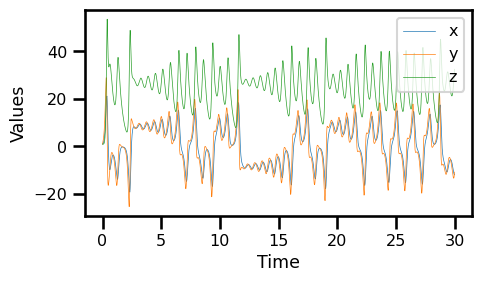

In [17]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.plot(ts, out.x, lw=0.5, label="x")
ax.plot(ts, out.y, lw=0.5, label="y")
ax.plot(ts, out.z, lw=0.5, label="z")
ax.set_xlabel("Time")
ax.set_ylabel("Values")
plt.legend()
plt.tight_layout()
plt.show()

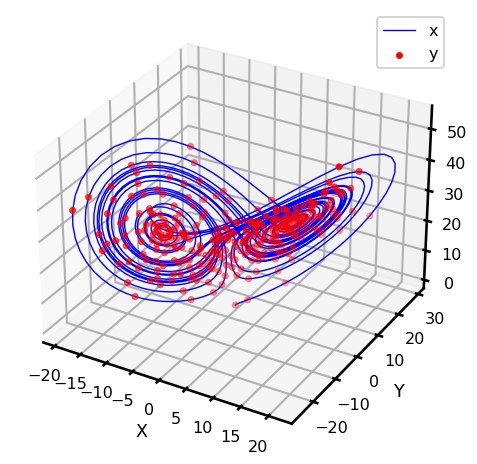

In [36]:
fig, ax = plt.subplots(
    subplot_kw={"projection": "3d"}
)  # plt.figure().add_subplot(projection="3d")

ax.plot(out.x, out.y, out.z, lw=1.0, color="blue", label="x")
ax.scatter3D(out.x[::10], out.y[::10], out.z[::10], lw=0.5, color="red", label="y")

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
state_batch = L63State.init_state_batch(batchsize=10, noise=0.01)

fn_batched = jax.vmap(rhs_lorenz_63, in_axes=(0, None, None, None))

state_dot_batch = fn_batched(state_batch, s, r, b)
x_dot, y_dot, z_dot = state_dot_batch
# state_dot_batch = fn_batched(state_batch)

assert x_dot.shape == y_dot.shape == z_dot.shape == state_batch.x.shape
assert state_batch.x.shape == state_batch.y.shape == state_batch.z.shape == x_dot.shape

In [6]:
# import jax.random as jrandom


# key = jrandom.PRNGKey(seed=123)

In [7]:
# n_batches = 32
# s, r, b = 10, 28, 2.667
# dt = 0.01
# t0 = 0.0
# t1 = 30.0
# observe_every = 10
# n_steps = len(jnp.arange(t0, t1, dt))
# n_warmup_steps = 1000


# # define dynamical system
# model = Lorenz63(dt=dt, observe_every=observe_every, s=s, r=r, b=b)


# # initialize batch
# x0 = model.init_x0_batch(n_batches, 0.01)


# # perform integration (warmup, batches)
# x_warmup = model.batch_warmup(x0, n_warmup_steps)
# assert x_warmup.shape == (n_batches, 3)

# # perform integration (batches)
# x, t = model.batch_integrate(x_warmup, n_steps)
# assert x.shape == (n_batches, n_steps, 3)

# # do observation operator
# y, t_obs = model.batch_observe(x, n_steps)

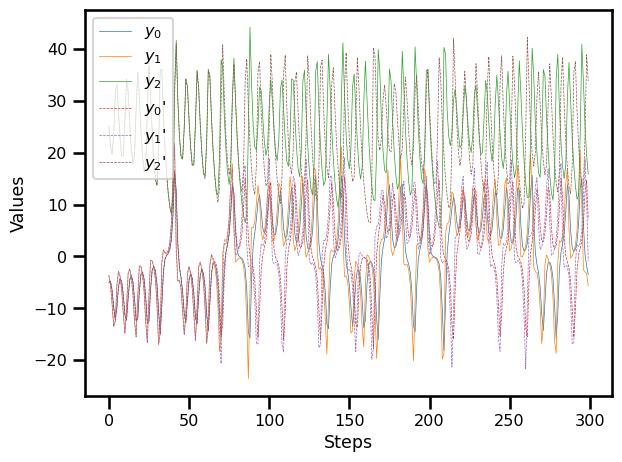

In [8]:
# fig, ax = plt.subplots()

# ax.plot(y[30], linewidth=0.5, label=["$y_0$", "$y_1$", "$y_2$"])
# ax.plot(y[100], linewidth=0.5, linestyle="--", label=["$y_0$'", "$y_1$'", "$y_2$'"])
# ax.set_xlabel("Steps")
# ax.set_ylabel("Values")
# plt.legend()
# plt.tight_layout()
# plt.show()

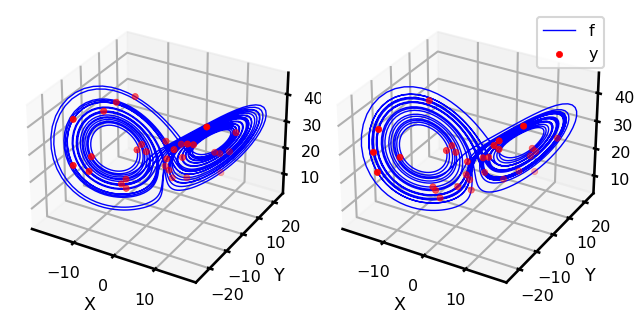

In [9]:
# fig = plt.figure()

# ax = fig.add_subplot(1, 2, 1, projection="3d")

# ax.plot(*x[30].T, lw=1.0, color="blue")
# ax.scatter3D(*y[30, ::10].T, lw=0.5, color="red")
# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")

# ax = fig.add_subplot(1, 2, 2, projection="3d")
# ax.plot(*x[100].T, lw=1.0, color="blue", label="f")
# ax.scatter3D(*y[100, ::10].T, lw=0.5, color="red", label="y")
# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")
# plt.legend()
# plt.tight_layout()
# plt.show()

## Lorenz 96

* Equation of Motion
* Observation Operator
* Integrate

### Equation of Motion

$$
\frac{dx}{dt} = (x_{i+1} - x_{i-2})x_{i-1}-x_i+F
$$

where $F$ is normally 8 to cause some chaotic behaviour.

In [10]:
# grid_size = 50
# F = 8
# dt = 0.01
# t0 = 0.0
# t1 = 30.0
# observe_every = 10
# n_steps = len(jnp.arange(t0, t1, dt))


# # define dynamical system
# model = Lorenz96(dt=dt, grid_size=grid_size, observe_every=observe_every, F=F)

# # initialize trajectory
# x0 = model.init_x0(0.01)

# # perform integration (warmup)
# x_warmup = model.warmup(x0, n_steps)
# assert x_warmup.shape == (grid_size,)

# # perform integration
# x, t = model.integrate(x_warmup, n_steps)
# assert x.shape == (n_steps, grid_size)

# # do observation operator
# y, t_obs = model.observe(x, n_steps)

In [11]:
# t.min(), t.max(), t_obs.min(), t_obs.max()

(Array(0., dtype=float32),
 Array(29.99, dtype=float32),
 Array(0., dtype=float32),
 Array(29.9, dtype=float32))

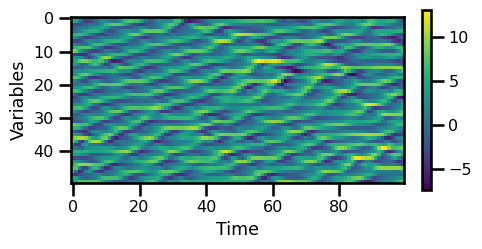

In [12]:
# fig, ax = plt.subplots(figsize=(5, 3))

# pts = ax.imshow(y[-100:].T)
# fig.colorbar(pts, cmap="viridis", fraction=0.025)
# ax.set_xlabel("Time")
# ax.set_ylabel("Variables")
# plt.tight_layout()
# plt.show()

In [13]:
import jax.random as jrandom


key = jrandom.PRNGKey(seed=123)

In [14]:
# grid_size = 50
# n_batches = 32
# F = 8
# dt = 0.01
# t0 = 0.0
# t1 = 30.0
# observe_every = 10
# n_steps = len(jnp.arange(t0, t1, dt))
# n_warmup_steps = 1000


# # define dynamical system
# model = Lorenz96(dt=dt, grid_size=grid_size, observe_every=observe_every, F=F)

# # initialize batch
# x0 = model.init_x0_batch(n_batches, 0.01)


# # perform integration (warmup, batches)
# x_warmup = model.batch_warmup(x0, n_warmup_steps)
# assert x_warmup.shape == (n_batches, grid_size)

# # perform integration (batches)
# x, t = model.batch_integrate(x_warmup, n_steps)
# assert x.shape == (n_batches, n_steps, grid_size)

# # do observation operator
# y, t_obs = model.batch_observe(x, n_steps)

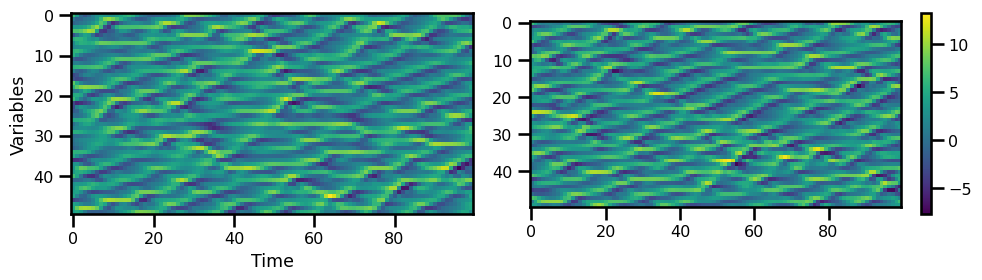

In [15]:
# fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

# pts = ax[0].imshow(y[100, -100:].T)

# pts = ax[1].imshow(y[30, -100:].T)
# plt.colorbar(pts, cmap="viridis", fraction=0.025)
# ax[0].set_xlabel("Time")
# ax[0].set_ylabel("Variables")
# plt.tight_layout()
# plt.show()